##  Principle: 
####  A good difference operator, conditioned on the commonality between two objects would make an "equality" discriminator incapable of discerning the two objects.

In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 2
setup_one_gpu(GPU)

Picking GPU 2


In [2]:
import tensorflow as tf
import numpy as np
from tflearn.layers.conv import conv_1d
from tf_lab.point_clouds.encoders_decoders import encoder_with_convs_and_symmetry_new, decoder_with_fc_only
from tf_lab.external.structural_pc_losses import losses
from general_tools.notebook.tf import reset_tf_graph
from tf_lab.data_sets.numpy_dataset import NumpyDataset
from geo_tool import Point_Cloud

from tf_lab.iclr.helper import load_multiple_version_of_pcs
from pc_completions.helper import load_pretrained_ae_from_iclr
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from tf_lab.point_clouds.convenience import get_latent_codes
from general_tools.clustering.convenience import find_nearest_neighbors

In [3]:
%matplotlib inline

In [4]:
nn_distance, approx_match, match_cost = losses()

In [5]:
reset_tf_graph()
# sess = tf.InteractiveSession()

n_points = 2048
pc_dim = 3
n_classes = 2

x = tf.placeholder(tf.float32, [None, n_points, pc_dim])
y = tf.placeholder(tf.float32, [None, n_points, pc_dim])
l = tf.placeholder(tf.float32, [None, n_classes])


enc_filters = [64, 128, 128, 256]
split_of_embedding = 0.5
dim_thres = int(enc_filters[-1] * split_of_embedding)

mask_neurons = [100, 100, n_points]
decoder_neurons = [128, 256, n_points * 3]
discriminator_neurons = [128, 256]
gen_neurons = [128, 256]

# with tf.variable_scope('encoder') as scope:    
#     zx = encoder_with_convs_and_symmetry_new(x, n_filters=enc_filters, b_norm=False, scope=scope)
#     zx_sim = zx[:, :dim_thres]
#     zx_dissim = zx[:, dim_thres:]
    
#     zy = encoder_with_convs_and_symmetry_new(y, n_filters=enc_filters, b_norm=False, scope=scope, reuse=True)
#     zy_sim = zy[:, :dim_thres]
#     zy_dissim = zy[:, dim_thres:]
    
# with tf.variable_scope('mask_creator') as scope:
#     mask = decoder_with_fc_only(zx, layer_sizes=mask_neurons, b_norm=False, scope=scope)
#     mask_x_sim = tf.sigmoid(mask) >= 0.5    
#     mask_x_dissim = tf.logical_not(mask_x_sim)    
#     mask_x_sim = tf.tile(tf.expand_dims(mask_x_sim, 2), [1, 1, pc_dim])  # TODO d-check
#     mask_x_sim = tf.cast(mask_x_sim, tf.float32)    
#     mask_x_dissim = tf.tile(tf.expand_dims(mask_x_dissim, 2), [1, 1, pc_dim])  # TODO d-check
#     mask_x_dissim = tf.cast(mask_x_dissim, tf.float32)
        
#     mask = decoder_with_fc_only(zy, layer_sizes=mask_neurons, b_norm=False, scope=scope, reuse=True)
#     mask_y_sim = tf.sigmoid(mask) >= 0.5
#     mask_y_dissim = tf.logical_not(mask_y_sim)    
#     mask_y_sim = tf.tile(tf.expand_dims(mask_y_sim, 2), [1, 1, pc_dim])  # TODO d-check
#     mask_y_sim = tf.cast(mask_y_sim, tf.float32)    
#     mask_y_dissim = tf.tile(tf.expand_dims(mask_y_dissim, 2), [1, 1, pc_dim])  # TODO d-check
#     mask_y_dissim = tf.cast(mask_y_dissim, tf.float32)

# with tf.variable_scope('sim_decoder') as scope:
#     x_sim_pred = decoder_with_fc_only(zx_sim, layer_sizes=decoder_neurons, b_norm=False, scope=scope)
#     x_sim_pred = tf.reshape(x_sim_pred, [-1, n_points, pc_dim])
#     y_sim_pred = decoder_with_fc_only(zy_sim, layer_sizes=decoder_neurons, b_norm=False, scope=scope, reuse=True)
#     y_sim_pred = tf.reshape(y_sim_pred, [-1, n_points, pc_dim])

# with tf.variable_scope('dissim_decoder') as scope:    
#     x_dissim_pred = decoder_with_fc_only(zx_dissim, layer_sizes=decoder_neurons, b_norm=False, scope=scope)
#     x_dissim_pred = tf.reshape(x_dissim_pred, [-1, n_points, pc_dim])
#     y_dissim_pred = decoder_with_fc_only(zy_dissim, layer_sizes=decoder_neurons, b_norm=False, scope=scope, reuse=True)
#     y_dissim_pred = tf.reshape(y_dissim_pred, [-1, n_points, pc_dim])
    
# with tf.variable_scope('ae_losses') as scope:
#     x_sim_masked = tf.multiply(x, mask_x_sim)
#     x_dissim_masked = tf.multiply(x, mask_x_dissim)    
    
#     y_sim_masked = tf.multiply(y, mask_y_sim)
#     y_dissim_masked = tf.multiply(y, mask_y_dissim)
    
#     l1, _, s1, _ = nn_distance(x_sim_pred, y_sim_masked)
#     l2, _, s2, _ = nn_distance(x_dissim_pred, x_dissim_masked)
#     l3, _, s3, _ = nn_distance(y_sim_pred, x_sim_masked)
#     l4, _, s4, _ = nn_distance(y_dissim_pred, y_dissim_masked)    
#     ae_loss = tf.reduce_mean(l1 + l2 + l3 + l4)
#     ae_loss += tf.reduce_mean(s1 + s2 + s3 + s4)        

# with tf.variable_scope('generator') as scope:    
#     gen_in = tf.concat([zx_sim, zy_dissim, zx_dissim], axis=1)
#     gen_out = decoder_with_fc_only(gen_in, layer_sizes=gen_neurons + [dim_thres], b_norm=False, scope=scope)
#     gen_out = tf.nn.relu(gen_out)
#     gen_labels = tf.zeros_like(l)
    
# with tf.variable_scope('discriminator') as scope:
#     l_sizes = discriminator_neurons + [n_classes]
#     data_sim = tf.concat([zx_sim, zy_sim], axis=1)
#     data_logit = decoder_with_fc_only(data_sim, layer_sizes=l_sizes, b_norm=False, scope=scope)    
#     gen_sim = tf.concat([zx_sim, gen_out], axis=1)
#     gen_logit = decoder_with_fc_only(gen_sim, layer_sizes=l_sizes, b_norm=False, scope=scope, reuse=True)
    
# with tf.variable_scope('consistency_losses'):    
#     d_data_loss = tf.reduce_mean(tf.losses.log_loss(labels=l, predictions=tf.nn.softmax(data_logit)))
#     d_gen_loss = tf.reduce_mean(tf.losses.log_loss(labels=gen_labels, predictions=tf.nn.softmax(gen_logit)))
#     generator_push = -tf.reduce_mean(tf.losses.log_loss(labels=gen_labels, predictions=tf.nn.softmax(gen_logit)))

In [138]:
# train_vars = tf.trainable_variables()

# def starts_with_any(name, list_of_names):
#     res = False
#     for n in list_of_names:
#         if name.startswith(n):
#             return True
#     return res

# ae_name_space = ['encoder', 'mask_creator', 'sim_decoder', 'dissim_decoder']
# ae_params = [v for v in train_vars if starts_with_any(v.name, ae_name_space) ]

total_loss = ae_loss + d_data_loss + d_gen_loss + generator_push

In [43]:
reset_tf_graph()

x = tf.placeholder(tf.float32, [None, n_points, pc_dim])
y = tf.placeholder(tf.float32, [None, n_points, pc_dim])

dp0 = tf.placeholder(tf.float32, None)
dp2 = tf.placeholder(tf.float32, None)

dps = [dp0, 0, dp2, 0]

with tf.variable_scope('encoder') as scope:    
    zx = encoder_with_convs_and_symmetry_new(x, n_filters=enc_filters, b_norm=False, dropout_prob=dps, scope=scope)
    zx_sim = zx[:, :dim_thres]
    zx_dissim = zx[:, dim_thres:]
    
    zy = encoder_with_convs_and_symmetry_new(y, n_filters=enc_filters, b_norm=False, dropout_prob=dps, scope=scope, reuse=True)
    zy_sim = zy[:, :dim_thres]
    zy_dissim = zy[:, dim_thres:]

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
init=tf.global_variables_initializer()
sess.run(init)

In [47]:
batch_size = 1
# x_batch, y_batch = train_data.next_batch(batch_size)
feed_dict = {x:x_batch, y:y_batch, dp0:0.5, dp2:0.5}
y0, y1 = sess.run([zx_sim, zy_sim], feed_dict=feed_dict)

In [48]:
y1 == y0

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
      

In [10]:
train_data = NumpyDataset([train_clouds, train_clouds], ['x', 'y'])   # overload what happens when epoch is reached.

['x', 'y']


In [139]:
init_lr = 0.0001
optimizer = tf.train.AdamOptimizer(init_lr)
step = optimizer.minimize(total_loss)

# a = optimizer.compute_gradients(ae_loss, ae_params)
# d_params = [v for v in train_vars if starts_with_any(v.name, ['discriminator'])]
# b = tf.gradients(d_data_loss, [zx_sim, zy_sim])
# # b = optimizer.compute_gradients(d_data_loss, [zx_sim])
# # c = tf.gradients(d_gen_loss, [zx_sim])
# # d = tf.gradients(generator_push, [zx_dissim, zy_dissim])

In [21]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
init=tf.global_variables_initializer()
sess.run(init)

In [9]:
class_name = 'chair'
syn_id = snc_category_to_synth_id()[class_name]
in_data = load_multiple_version_of_pcs('uniform_one', syn_id, n_classes=1)
train_clouds = in_data['train'].point_clouds

679 pclouds were loaded. They belong in 1 shape-classes.
5761 pclouds were loaded. They belong in 1 shape-classes.
338 pclouds were loaded. They belong in 1 shape-classes.


In [29]:
# from tf_lab.point_clouds.convenience import reconstruct_pclouds
# pretrained_ae = load_pretrained_ae_from_iclr(class_name=class_name, loss='emd', bneck=128, pc_type='uniform_one')
# latent_codes = get_latent_codes(ae, train_data.point_clouds)
# recon_pclouds, loss_val = reconstruct_pclouds(pretrained_ae, train_data.point_clouds, 100)
# print 'Loss of reconstructed data ', loss_val

Loss of reconstructed data  88.2121935651


In [58]:
comparators = train_clouds.copy() 
np.random.shuffle(comparators)
train_data = NumpyDataset([train_clouds, comparators], ['x', 'y'])   # overload what happens when epoch is reached.

['x', 'y']


In [59]:
batch_size = 128
max_epochs = 10

batches_for_epoch = train_data.n_examples / batch_size

for _ in range(max_epochs):
    for _ in range(batches_for_epoch):
        x_batch, y_batch = train_data.next_batch(batch_size)
        feed_dict = {x:x_batch, y:y_batch}
        sess.run([step], feed_dict=feed_dict)[0]
    print sess.run([total_loss], feed_dict=feed_dict)[0]

0.00493877
0.00495933
0.00488627
0.00491785
0.00476415
0.00484228
0.0050008
0.00489942
0.00502547
0.00495341


In [60]:
x_batch, y_batch = train_data.next_batch(10)
feed_dict = {x:x_batch, y:y_batch}
# sess.run([step], feed_dict=feed_dict)[0]    
# o1, o2 = sess.run([mask_x_sim, mask_x_dissim], feed_dict=feed_dict)
o1, o2, o3, o4 = sess.run([x_sim_pred, y_sim_pred, x_dissim_pred, y_dissim_pred], feed_dict=feed_dict)
# o1, o2, o3, o4 = sess.run([x_sim_masked, x_dissim_masked, y_sim_masked, y_dissim_masked], feed_dict=feed_dict)

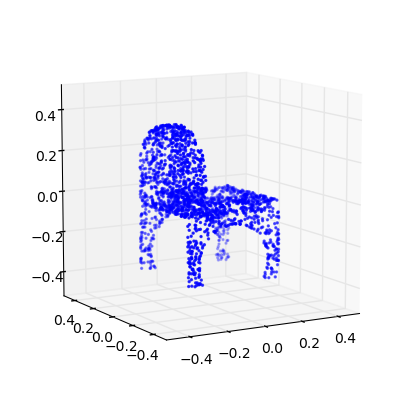

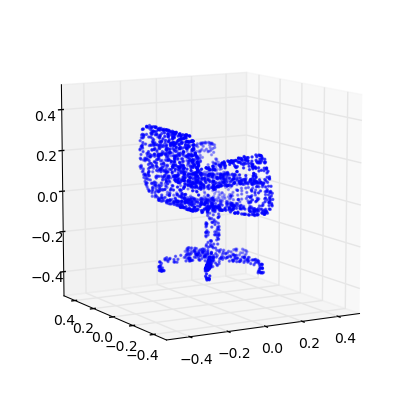

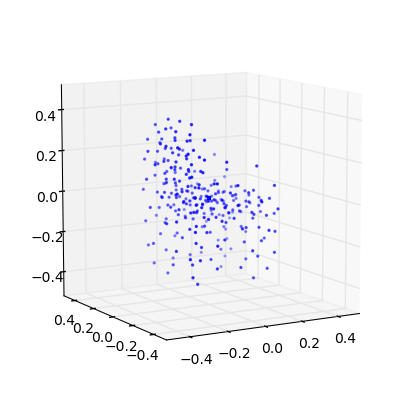

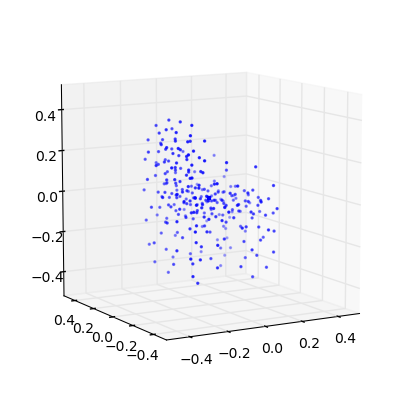

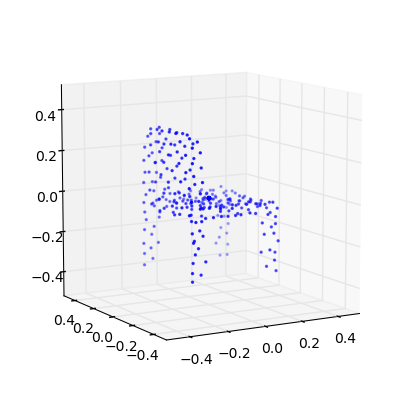

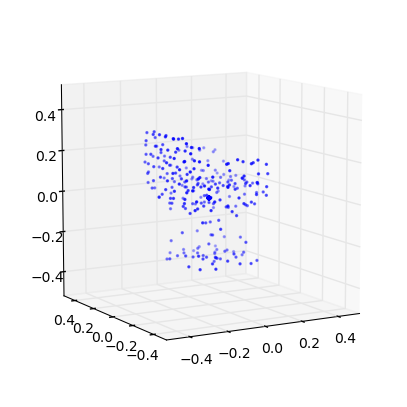

In [61]:
k = 1
Point_Cloud(x_batch[k]).plot();
Point_Cloud(y_batch[k]).plot();

Point_Cloud(o1[k]).plot();
Point_Cloud(o2[k]).plot();

Point_Cloud(o3[k]).plot();
Point_Cloud(o4[k]).plot();

<tf.Tensor 'Mul_4:0' shape=(?, 2048, 3) dtype=float32>

In [102]:
# b = 5
# n_p = 1
# A = tf.reshape(tf.range(b*n_p), [b, n_p])
# print A.eval()
# tf.tile(tf.expand_dims(A, 2), [1,1,3]).eval()

[[0]
 [1]
 [2]
 [3]
 [4]]


array([[[0, 0, 0]],

       [[1, 1, 1]],

       [[2, 2, 2]],

       [[3, 3, 3]],

       [[4, 4, 4]]], dtype=int32)

<tf.Tensor 'Tile_12:0' shape=(?, 2048, 3) dtype=bool>

In [8]:
# g = tf.get_default_graph()

[<tf.Variable 'encoder/encoder/encoder_conv_layer_0/W:0' shape=(1, 1, 3, 64) dtype=float32_ref>,
 <tf.Variable 'encoder/encoder/encoder_conv_layer_0/b:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'encoder/encoder/encoder_conv_layer_1/W:0' shape=(1, 1, 64, 128) dtype=float32_ref>,
 <tf.Variable 'encoder/encoder/encoder_conv_layer_1/b:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'encoder/encoder/encoder_conv_layer_2/W:0' shape=(1, 1, 128, 128) dtype=float32_ref>,
 <tf.Variable 'encoder/encoder/encoder_conv_layer_2/b:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'encoder/encoder/encoder_conv_layer_3/W:0' shape=(1, 1, 128, 256) dtype=float32_ref>,
 <tf.Variable 'encoder/encoder/encoder_conv_layer_3/b:0' shape=(256,) dtype=float32_ref>]

<tf.Tensor 'strided_slice_2:0' shape=(?, 128) dtype=float32>